In [184]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader




In [185]:
! pip install torch

In [186]:
import random
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
set_seed(40)

In [187]:
#Load Data
partially_processed_path = './CS-4641-NBA-All-Star/data/partially_processed/advanced_player_season_totals.csv'
dataset = pd.read_csv(partially_processed_path)

#print(dataset.columns)
#print(dataset)

#X, y = dataset.drop(["name", "is_all_star"], axis=1), dataset["is_all_star"]

X = dataset.drop(['name'],axis=1)

#One-Hot Encode Player Position
encoded = pd.get_dummies(X["positions"], prefix="POS")
X = pd.merge(left=X.drop("positions", axis=1), right=encoded, left_index=True, right_index=True)


In [188]:
#normalize every player feature based on position and season
positions = ['POS_CENTER', 'POS_POINT GUARD', 'POS_POWER FORWARD', 'POS_SHOOTING GUARD', 'POS_SMALL FORWARD']
years = X['season'].unique()

working_X = []
for pos in positions:
    for year in years:
        #get players for a particular year and find means and variances for every feature
        #current = X.where(X[pos] == 1 & X['season'] == year)

        current = X[(X[pos] == 1) & (X['season'] == year)]
        current = current.drop(columns=['season'])

        all_star_col = current['is_all_star']
        current = current.drop(columns=['is_all_star'])        

        position_cols = current[positions]
        current = current.drop(columns=positions)

        current = (current - current.mean())/current.std()
        current[positions] = position_cols
        current['is_all_star'] = all_star_col
        working_X.append(current)

X = pd.concat(working_X)

In [189]:
SEED = 69
train_ratio = 0.3
test_ratio = 0.4
val_ratio = 0.4

X_train, X_tmp = train_test_split(X, test_size=test_ratio+val_ratio)
X_test, X_val = train_test_split(X_tmp,test_size=val_ratio/(val_ratio + test_ratio))

In [190]:

all_stars = X_train[X_train['is_all_star'] == 1]
non_all_stars = X_train[X_train['is_all_star'] == 0]
all_stars = all_stars.sample(n=non_all_stars.shape[0], replace = True)
X_train = pd.concat([all_stars, non_all_stars])
X_train = X_train.sample(frac=1)


In [191]:
#X.head()
X_train[X_train['is_all_star'] == 0]

,age,games_played,minutes_played,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,...,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player,POS_CENTER,POS_POINT GUARD,POS_POWER FORWARD,POS_SHOOTING GUARD,POS_SMALL FORWARD,is_all_star
6734,-0.753171,0.674269,1.178913,1.071485,0.311723,-0.835645,-0.010022,0.046861,0.849945,0.692235,...,0.831510,0.775970,1.047724,1.659642,0,0,0,1,0,0
5428,-0.415603,0.196471,-0.138489,0.116430,0.675130,-0.359998,-0.265388,-0.000679,0.281979,0.127318,...,-0.221953,0.053915,-0.120694,-0.558297,1,0,0,0,0,0
7575,1.787309,-0.054050,-0.426781,0.001226,0.255264,-0.612402,0.139133,-0.385126,-0.624088,-0.635888,...,-0.242846,0.005211,-0.188984,-0.503370,1,0,0,0,0,0
3173,1.560288,-0.971294,-1.049221,-0.185901,0.611906,-0.543943,1.434163,0.103573,-0.575430,-0.159298,...,-0.430955,0.312872,-0.310481,-0.585643,0,0,1,0,0,0
8599,2.165727,0.152439,0.546904,-0.850383,-0.264555,1.714113,-0.812321,-0.937894,-0.204741,-0.739111,...,-0.060725,0.892359,0.560640,0.524044,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8498,-0.746268,0.559457,0.703148,-0.251388,-0.017507,-1.231603,0.171642,1.448986,1.048166,1.214917,...,-0.288336,0.664468,-0.000786,-0.314937,0,1,0,0,0,0
9427,-0.386264,-0.110302,-0.607398,0.098357,0.528173,1.806973,-0.406064,-1.204617,-1.493168,-1.697390,...,0.414008,-1.012785,-0.062613,-0.393005,0,0,0,0,1,0
1472,-1.223415,0.644979,0.163050,0.280581,-0.407911,1.831858,-0.820090,0.203803,1.011576,0.868915,...,0.319873,0.214764,0.332995,0.014023,0,0,1,0,0,0
321,0.869016,0.631595,0.332159,0.296298,1.186729,1.562071,0.037470,-0.280423,-0.397267,-0.455031,...,0.746876,-0.172002,0.572104,0.214527,0,0,0,1,0,0


In [192]:
'''
#split dataset into 60/20/20 for training, testing, validation
SEED = 69
train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2



X, y = X.drop(columns=['is_all_star']), X['is_all_star']

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=test_ratio+val_ratio)
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=val_ratio/(val_ratio + test_ratio))
'''
X_train, y_train = X_train.drop(columns=['is_all_star']), X_train['is_all_star']
X_test, y_test = X_test.drop(columns=['is_all_star']), X_test['is_all_star']
X_val, y_val = X_val.drop(columns=['is_all_star']), X_val['is_all_star']

#convert data to tensors
X_train, X_test, X_val = torch.LongTensor(X_train.values), torch.LongTensor(X_test.values), torch.LongTensor(X_val.values)
y_train, y_test, y_val = torch.LongTensor(y_train.values), torch.LongTensor(y_test.values), torch.LongTensor(y_val.values)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

torch.Size([3584, 28]) torch.Size([3799, 28]) torch.Size([3800, 28])
torch.Size([3584]) torch.Size([3799]) torch.Size([3800])


In [193]:
class dataset(Dataset):
  def __init__(self,X,y):
    self.X = X.float()
    self.y = y.float()
    self.length = self.X.shape[0]
 
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]
  def __len__(self):
    return self.length

In [194]:
class AllStarClassifier(nn.Module):
    def __init__(self, LAYER_1=30, LAYER_2=10, LAYER_3 = 10, LAYER_4 = 10):
      super(AllStarClassifier, self).__init__()
      # dense layers
      self.layer1 = nn.Linear(LAYER_1, LAYER_2)
      self.layer2 = nn.Linear(LAYER_2,  LAYER_3)
      self.layer3 = nn.Linear(LAYER_3,  LAYER_4)
      self.layer4 = nn.Linear(LAYER_4,  1)

    def forward(self, X):

      X = self.layer1(X)
      X = F.relu(X)
      X = self.layer2(X)
      X = F.relu(X)
      X = self.layer3(X)
      X = F.relu(X)
      X = self.layer4(X)
      return torch.sigmoid(X)

In [195]:
loss_fn = nn.BCELoss()

learning_rate = 0.1
num_epochs = 10
batch_size = 16

In [196]:
train_set = dataset(X_train,y_train)
test_set = dataset(X_test,y_test)
val_set = dataset(X_val,y_val)
#DataLoader
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False)

In [197]:
def EvalNet(dev_loader, net):
    num_correct = 0
    epoch_accuracy = []
    epoch_loss = []
    y_pred = []
    y_actual = []
    for i,(X,y) in enumerate(dev_loader):
        output = net.forward(X)

        loss = loss_fn(output,y.reshape(-1,1))
        epoch_loss.append(loss.detach().numpy())

        #get pred and actual values
        y_pred.append(output.detach().numpy().round().reshape((output.shape[0])))
        y_actual.append(y.detach().numpy().reshape((y.shape[0])))

        accuracy = (output.reshape(-1).detach().numpy().round() == y.detach().numpy()).sum()/X.shape[0]
        epoch_accuracy.append(accuracy)

    eval_loss_list.append(sum(epoch_loss)/len(epoch_loss))
    eval_accuracy_list.append(sum(epoch_accuracy) / len(epoch_accuracy))

    y_pred = np.concatenate(y_pred)
    y_actual = np.concatenate(y_actual)

    print("Accuracy: %s" % (sum(epoch_accuracy) / len(epoch_accuracy)))

    return y_actual, y_pred

def Metrics(dev_loader, net):
  y, y_pred = EvalNet(dev_loader, net)
  conversion_dict = {0: 'Non-All-Star' ,1: 'All-Star'}
  processed_y, processed_y_pred = [],[]
  for i in range(len(y)):
    processed_y.append(conversion_dict[y[i]])
    processed_y_pred.append(conversion_dict[y_pred[i]])
  print(classification_report(processed_y, processed_y_pred, labels=['Non-All-Star', 'All-Star']))

def Train(net, train_loader, n_iter, dev_loader, learning_rate=0.01):
  print("Start Training!")
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  for epoch in range(n_iter):
    total_loss = 0.0
    epoch_accuracy = []
    epoch_loss = []
    net.train()   #Put the network into training mode
    for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):
      output = net(X)
      
      loss = loss_fn(output,y.reshape(-1,1))
      epoch_loss.append(loss.detach().numpy())

      accuracy = (output.reshape(-1).detach().numpy().round() == y.detach().numpy()).sum()/(X.shape[0])
      epoch_accuracy.append(accuracy)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      

    train_accuracy_list.append(sum(epoch_accuracy)/len(epoch_accuracy))
    train_loss_list.append(sum(epoch_loss)/len(epoch_loss))
    
    net.eval()
    with torch.no_grad():
      print(f"Loss on Train {epoch} = {sum(epoch_loss)/len(epoch_loss)}")
      Metrics(dev_loader, net)
  return net

In [198]:
set_seed(100)

eval_loss_list = []
train_loss_list = []
eval_accuracy_list = []
train_accuracy_list = []

as_classifier = AllStarClassifier(LAYER_1=X_train.shape[1], LAYER_2=30, LAYER_3=15, LAYER_4=5)
trained_nn = Train(as_classifier, train_loader, num_epochs, val_loader)


Start Training!


/var/folders/qb/y1tbczls1jq3tcnsg6h5cd700000gn/T/ipykernel_49053/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 0 = 0.16610859768531686
Accuracy: 0.9514180672268907
              precision    recall  f1-score   support

Non-All-Star       0.99      0.96      0.97      3600
    All-Star       0.52      0.87      0.65       200

    accuracy                           0.95      3800
   macro avg       0.76      0.91      0.81      3800
weighted avg       0.97      0.95      0.96      3800



/var/folders/qb/y1tbczls1jq3tcnsg6h5cd700000gn/T/ipykernel_49053/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 1 = 0.10523391344967033
Accuracy: 0.9351365546218487
              precision    recall  f1-score   support

Non-All-Star       1.00      0.94      0.96      3600
    All-Star       0.44      0.92      0.60       200

    accuracy                           0.94      3800
   macro avg       0.72      0.93      0.78      3800
weighted avg       0.97      0.94      0.95      3800



/var/folders/qb/y1tbczls1jq3tcnsg6h5cd700000gn/T/ipykernel_49053/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 2 = 0.0767824810183291
Accuracy: 0.9556197478991597
              precision    recall  f1-score   support

Non-All-Star       0.99      0.96      0.98      3600
    All-Star       0.55      0.85      0.67       200

    accuracy                           0.96      3800
   macro avg       0.77      0.91      0.82      3800
weighted avg       0.97      0.96      0.96      3800



/var/folders/qb/y1tbczls1jq3tcnsg6h5cd700000gn/T/ipykernel_49053/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 3 = 0.06461969367540275
Accuracy: 0.9566701680672269
              precision    recall  f1-score   support

Non-All-Star       0.99      0.96      0.98      3600
    All-Star       0.56      0.84      0.67       200

    accuracy                           0.96      3800
   macro avg       0.77      0.90      0.82      3800
weighted avg       0.97      0.96      0.96      3800



/var/folders/qb/y1tbczls1jq3tcnsg6h5cd700000gn/T/ipykernel_49053/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 4 = 0.0662438799154188
Accuracy: 0.9532563025210085
              precision    recall  f1-score   support

Non-All-Star       0.99      0.96      0.97      3600
    All-Star       0.53      0.84      0.66       200

    accuracy                           0.95      3800
   macro avg       0.76      0.90      0.81      3800
weighted avg       0.97      0.95      0.96      3800



/var/folders/qb/y1tbczls1jq3tcnsg6h5cd700000gn/T/ipykernel_49053/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 5 = 0.05706683878815966
Accuracy: 0.961922268907563
              precision    recall  f1-score   support

Non-All-Star       0.99      0.97      0.98      3600
    All-Star       0.61      0.75      0.67       200

    accuracy                           0.96      3800
   macro avg       0.80      0.86      0.83      3800
weighted avg       0.97      0.96      0.96      3800



/var/folders/qb/y1tbczls1jq3tcnsg6h5cd700000gn/T/ipykernel_49053/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 6 = 0.05007954952348622
Accuracy: 0.9571953781512605
              precision    recall  f1-score   support

Non-All-Star       0.99      0.96      0.98      3600
    All-Star       0.56      0.83      0.67       200

    accuracy                           0.96      3800
   macro avg       0.78      0.90      0.82      3800
weighted avg       0.97      0.96      0.96      3800



/var/folders/qb/y1tbczls1jq3tcnsg6h5cd700000gn/T/ipykernel_49053/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 7 = 0.039425772136382875
Accuracy: 0.9600840336134454
              precision    recall  f1-score   support

Non-All-Star       0.99      0.97      0.98      3600
    All-Star       0.60      0.74      0.66       200

    accuracy                           0.96      3800
   macro avg       0.79      0.86      0.82      3800
weighted avg       0.96      0.96      0.96      3800



/var/folders/qb/y1tbczls1jq3tcnsg6h5cd700000gn/T/ipykernel_49053/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 8 = 0.036916705579902294
Accuracy: 0.9529936974789915
              precision    recall  f1-score   support

Non-All-Star       0.99      0.96      0.97      3600
    All-Star       0.54      0.78      0.63       200

    accuracy                           0.95      3800
   macro avg       0.76      0.87      0.80      3800
weighted avg       0.96      0.95      0.96      3800



/var/folders/qb/y1tbczls1jq3tcnsg6h5cd700000gn/T/ipykernel_49053/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 9 = 0.04114928427004218
Accuracy: 0.9582457983193278
              precision    recall  f1-score   support

Non-All-Star       0.99      0.97      0.98      3600
    All-Star       0.58      0.76      0.66       200

    accuracy                           0.96      3800
   macro avg       0.78      0.86      0.82      3800
weighted avg       0.96      0.96      0.96      3800



In [199]:
print(dir(tqdm.tqdm_notebook))
print('tqdm_notebook' in dir(tqdm))
print(dir(tqdm.tqdm_notebook))

['__annotations__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
True
['__annotations__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [200]:
train_loss_list

[0.16610859768531686,
 0.10523391344967033,
 0.0767824810183291,
 0.06461969367540275,
 0.0662438799154188,
 0.05706683878815966,
 0.05007954952348622,
 0.039425772136382875,
 0.036916705579902294,
 0.04114928427004218]

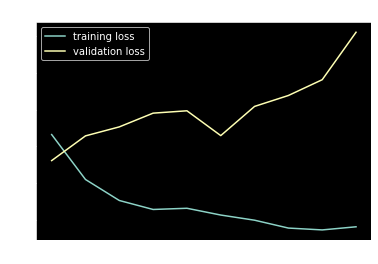

In [201]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_loss_list, label='training loss')
plt.plot(eval_loss_list, label='validation loss')
plt.title('Loss vs. Epochs Completed')
plt.legend()

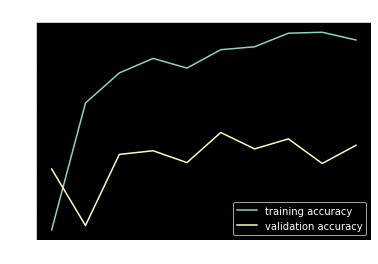

In [202]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_accuracy_list, label='training accuracy')
plt.plot(eval_accuracy_list, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()